In [1]:
import sys
sys.path
# !which pip

['/home/john/emg_decoder/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/john/.local/lib/python3.10/site-packages',
 '/home/john/emgdecomp',
 '/home/john/emg_decoder',
 '/home/john/rumi',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/john/.ipython']

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout
from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.train import train
from src.models.utils import Experiment

import importlib
import operator
from functools import reduce

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
rhythm_layout = ['a', 's', 'd', 'f']
binary_layout = [0, 1]
right_layout = ['j', 'k', 'l', ';']
six_finger_layout = ['a', 's', 'd', 'f', 'g', 'h']
new_layout = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
two_fingers_layout = ['g', 'h']
window_pre = 1000
window_post = 1000
subwindow_len = 480

In [3]:
data_dir = "/home/john/rumi/data/"

#expt_names = ["S1_2023-08-12-1314_Rhythm-Game-Typing-Task"] 
#             "S1_2023-08-12-1247_Rhythm-Game-Typing-Task"]

#expt_names = ["Shreyas_2023-08-14-1511_Rhythm-Game-Typing-Task", "Shreyas_2023-08-14-1549_Rhythm-Game-Typing-Task", "Shreyas_2023-08-14-1609_Rhythm-Game-Typing-Task"]
#expt_names = ["Shreyas_2023-08-14-1609_Rhythm-Game-Typing-Task"]
#expt_names = ["Shreyas-_2023-08-14-1644_Open-Loop-Typing-Task"]
#expt_names = ["John-Zhou_2023-08-11-1558_Rhythm-Game-Typing-Task"]
#expt_names = ["shretesting_2023-08-15-1536_Rhythm-Game-Typing-Task"]
# expt_names = ["Shreyas-Kaasyap_2023-08-24-1437_Open-Loop-Typing-Task"]
# expt_names = ["E1_2024-01-11-1345_Open-Loop-Typing-Task"]
#expt_names = ["Jacob_2024-02-23-1311_Rhythm-Game-Typing-Task"]
#expt_names = ["Jacob_2024-02-23-1358_Rhythm-Game-Typing-Task"]
#expt_names = ["Jacob_test_2024-02-28-1435_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_6finger_2024-02-28-1447_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_2024-03-01-1707_Rhythm-Game-Typing-Task"]
#expt_names = ["Jacob_2024-03-01-1739_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_test_2024-03-05-1547_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_2024-03-05-1552_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_test_2024-03-06-1323_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_2024-03-06-1328_Rhythm-Game-Typing-Task"]
# expt_names_test = ["Jacob_online_slow_2024-03-06-1520_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_2024-03-14-1615_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_test_2024-03-14-1637_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_test_2024-03-14-1644_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_test_electrodes_2024-03-14-1649_Rhythm-Game-Typing-Task"]
# expt_names_test = ["Jacob_online_fast_2024-03-06-1524_Rhythm-Game-Typing-Task"]
#expt_names_test = ["Jacob_offlinetest_2024-04-03-1524_Rhythm-Game-Typing-Task"]
#expt_names = ["Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task"]
# expt_names =  ["Jacob_2024-04-23-1033_Rhythm-Game-Typing-Task"]
# expt_names = ["Jacob_2024-04-25-1303_Rhythm-Game-Typing-Task"]
# expt_names = ["Derek_2024-07-11-1443_Rhythm-Game-Typing-Task"]
# expt_names = ["Derek_ball_2024-07-11-1547_Rhythm-Game-Typing-Task"]
# expt_names = ["Derek_2024-07-15-1303_Rhythm-Game-Typing-Task"]
#expt_names= ["jacob_2024-01-19-1448_Open-Loop-Typing-Task"]
# expt_names = ["jacob_2024-05-22-1414_Rhythm-Game-Typing-Task"]
# expt_names=["Jacob_2024-05-22-1500_Rhythm-Game-Typing-Task"]
# expt_names = ["Shreyas_2024-07-03-1510_Rhythm-Game-Typing-Task"]
# expt_names = ["Derek_ball_2024-07-15-1340_Rhythm-Game-Typing-Task"]
# expt_names=["kenfu_2024-04-09-1048_Rhythm-Game-Typing-Task"]
# expt_names = ["test_avg_2024-07-15-0259_Closed-Loop-Typing-Task/data_streams/emg_stream.bin"]
# expt_names = ["kenfu_2024-04-08-1718_Open-Loop-Typing-Task"]
# expt_names = ["Derek_table_2024-07-16-1628_Rhythm-Game-Typing-Task"]
# expt_names = ["nima_table_2024-07-23-1508_Rhythm-Game-Typing-Task"]
expt_names= ["derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task"]
# expt_names = ["Derek_official_2024-08-08-1421_Rhythm-Game-Typing-Task"]

def get_data(expt_list, layout):
    datasets = []

    for expt_name in expt_list:
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"
        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        print([chr(i) for i in key_data['keybuffer'][:80, 1]])
        
#         print(emg_data.shape)
#         for i in range(0, 100):
#            print(emg_data[i][-1])
        new_key_data = np.zeros(key_data.size, 
                                dtype=[('keybuffer', '<i8', (3,)), ('emg_stream_step', '<i8'), ('key_stream_step', '<i8'), ('time_ns', '<i8')])
        new_key_data['keybuffer'] = np.concatenate((np.zeros_like(key_data['keybuffer'][:, 1:2]), 
                                                key_data['keybuffer']), axis=1)
        new_key_data['emg_stream_step'] = key_data['emg_stream_step']
        new_key_data['key_stream_step'] = key_data['key_stream_step']
        new_key_data['time_ns'] = key_data['time_ns']

        emg_stream = emg_data['emgbuffer']
        
        
        
#         for i in new_key_data:
#            if(i[0][1] != 0):
#                print(i)
        
        dataset = KeyDataset(emg_stream, new_key_data, layout, window_pre, window_post, subwindow_len,
                             start_channel=1, 
                             end_channel=65, bipolar=False, avg_ref=True, binary=False, 
                             include_blanks=False, 
                             limit_blanks=False,
                             filter_params=None)

        datasets.append(dataset)
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [ ]:
emg_data = load_data(data_dir + "Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task" + "/data_streams/emg_stream.bin")
emg_data_test = load_data(data_dir + "Jacob_offlinetest_2024-04-03-1524_Rhythm-Game-Typing-Task" + "/data_streams/emg_stream.bin")

In [29]:
emg_data = load_data(data_dir + "jacob_2024-01-19-1448_Open-Loop-Typing-Task" + "/data_streams/emg_stream.bin")

71390


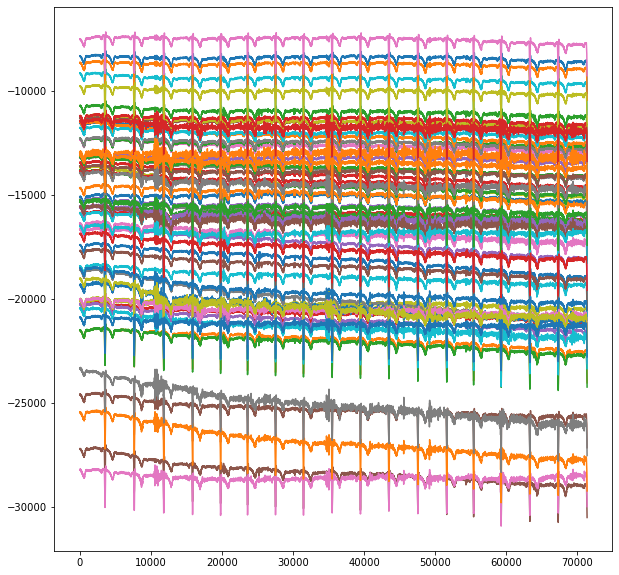

In [39]:
emg_data = load_data(data_dir + "test_avg_2024-07-15-0259_Closed-Loop-Typing-Task/data_streams/emg_stream.bin")
emg = emg_data['emgbuffer'][5000:, 1:65].copy()
print(len(emg))
plt.plot(emg)

In [30]:
# emg_data.dtype

In [31]:
# tmp = emg_data['emgbuffer'][:, 33:65].copy()
tmp = emg_data['emgbuffer'][:, 1:65].copy()
#tmp1 = emg_data_test['emgbuffer'][:, 1:65].copy()

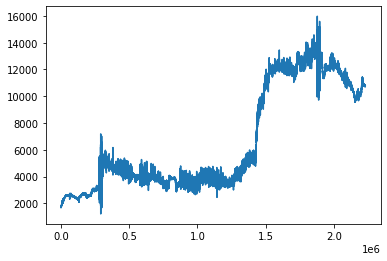

In [32]:
plt.plot(tmp[:, 4])
#plt.plot(tmp1[:, 0])

In [41]:
import scipy.signal
sos = scipy.signal.butter(6, 20/(4000/2), btype='high', output='sos')

In [42]:
sos

array([[ 0.94111111, -1.88222221,  0.94111111,  1.        , -1.94014813,
         0.94110595],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.95557824,
         0.95654368],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.98289279,
         0.98387171]])

In [43]:
scipy.signal.butter(4, 20.0, btype='high', output='sos', fs=4000.0)

array([[ 0.95978223, -1.91956446,  0.95978223,  1.        , -1.94263823,
         0.94359728],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.97526963,
         0.97624479]])

In [46]:
zi0 = scipy.signal.sosfilt_zi(sos)
zi = zi0[..., None] * emg[0]
fdata0, _ = scipy.signal.sosfilt(sos, emg, axis=0, zi=zi)

# zi = zi0[..., None] * tmp1[0]
# fdata1, _ = scipy.signal.sosfilt(sos, tmp1, axis=0, zi=zi)

In [47]:
zi0.shape

(3, 2)

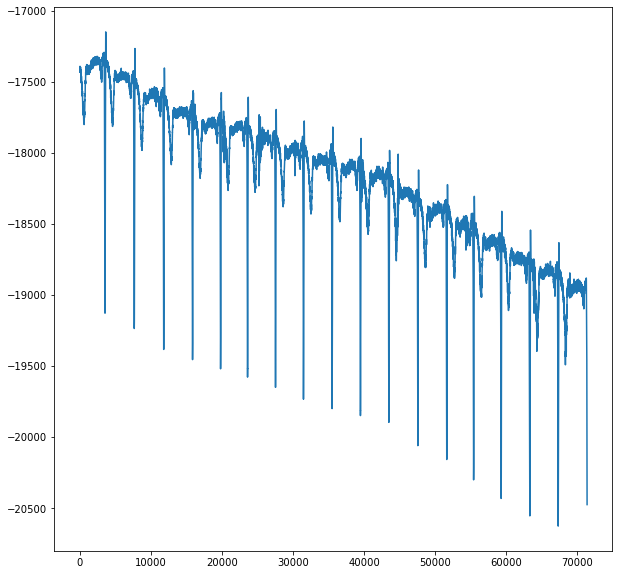

In [49]:
plt.plot(emg[:, 0])


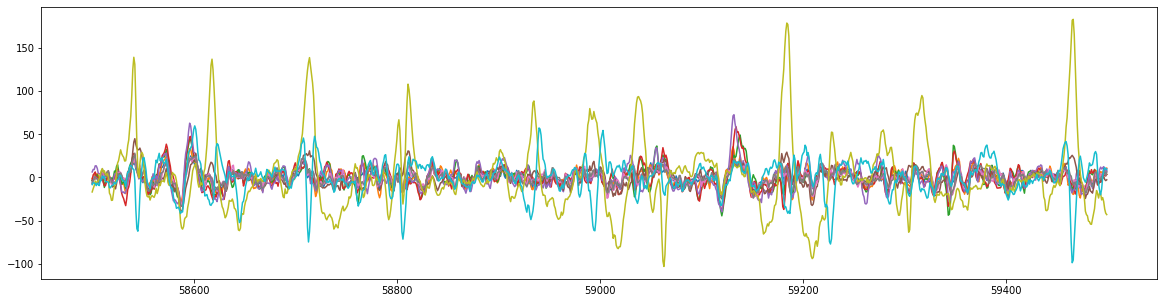

In [37]:
plt.figure(figsize=(20, 5))
start = 58500
L = 1000
plt.plot(np.arange(start, start+L), fdata0[start:start+L, 0:64:7])

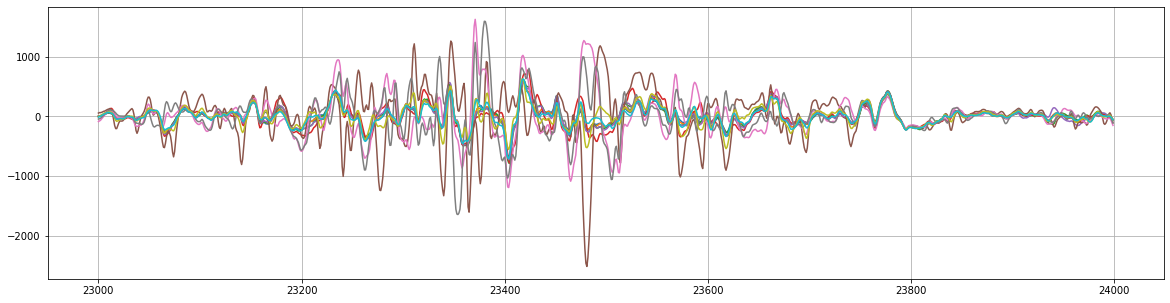

In [118]:
plt.figure(figsize=(20, 5))
start = 23000
L = 1000
plt.plot(np.arange(start, start+L), fdata1[start:start+L, 0:64:7])
plt.grid()

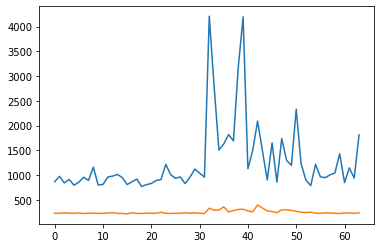

In [46]:
plt.plot(np.std(tmp, axis=0))
#plt.figure(2)
plt.plot(np.std(tmp1, axis=0))

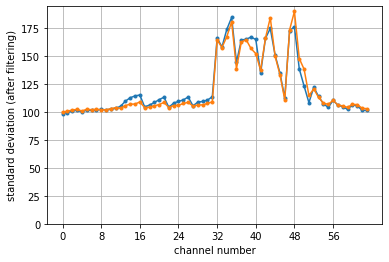

In [90]:
plt.plot(np.std(fdata0, axis=0), '.-')
#plt.figure(2)
plt.plot(np.std(fdata1, axis=0), '.-')
_ = plt.xticks(np.arange(8)*8)
#plt.yscale('log')
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('channel number')
plt.ylabel('standard deviation (after filtering)')
plt.grid()

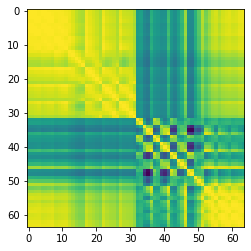

In [92]:
plt.imshow(np.corrcoef(fdata0.T))

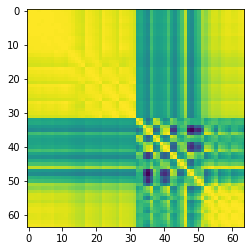

In [93]:
plt.imshow(np.corrcoef(fdata1.T))

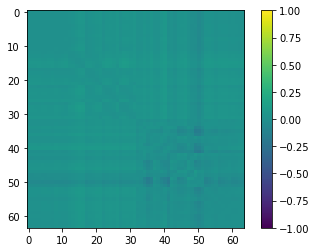

In [96]:
plt.imshow(np.corrcoef(fdata1.T) - np.corrcoef(fdata0.T), vmin=-1, vmax=1)
plt.colorbar()

KeyboardInterrupt: 

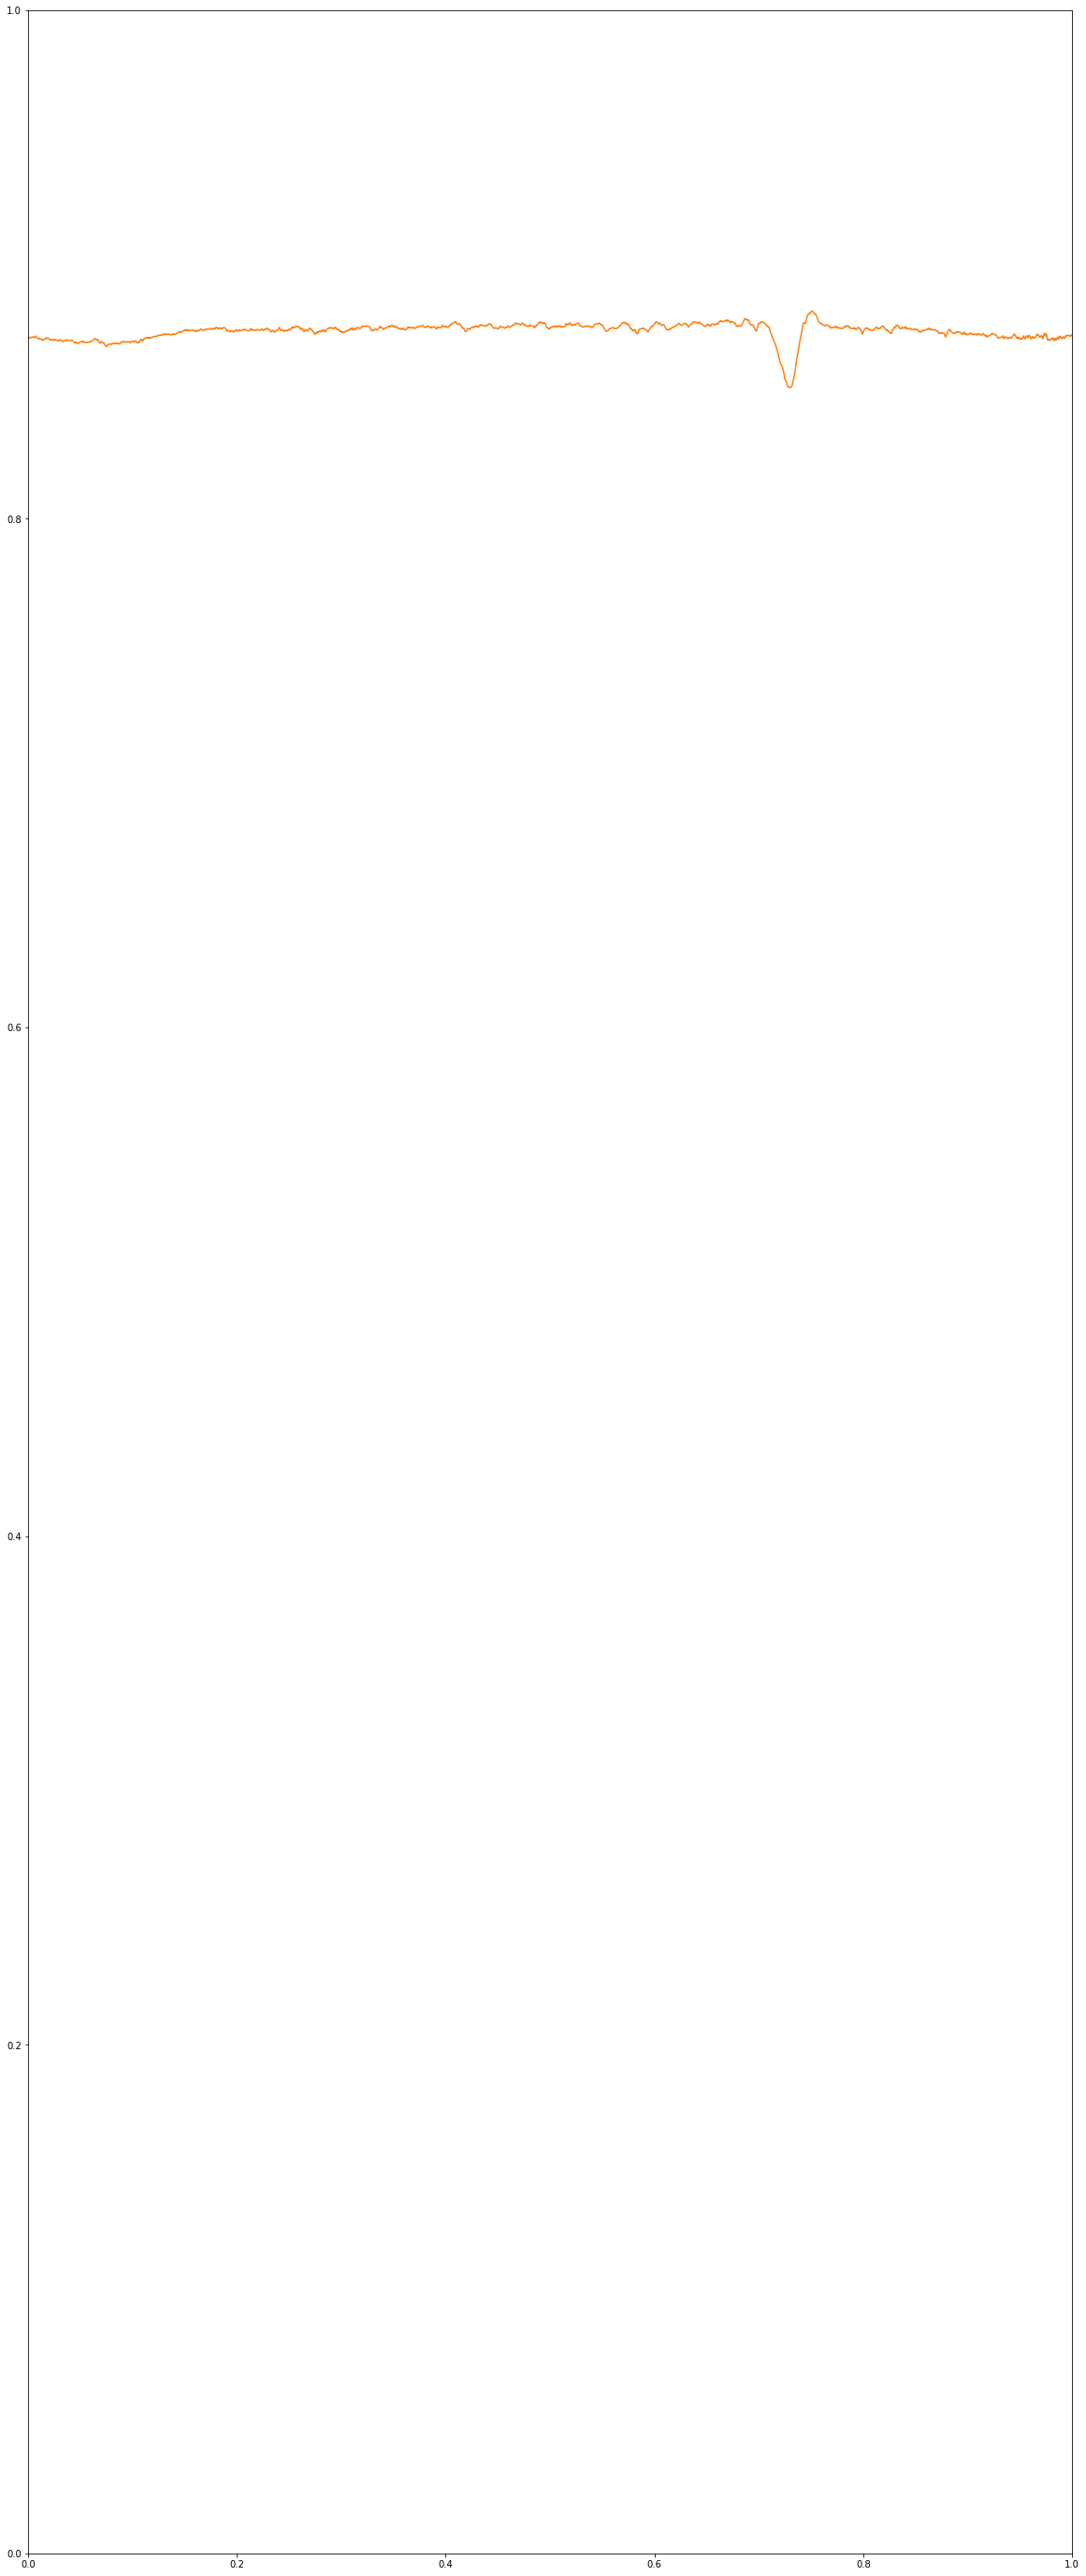

In [7]:
plt.figure(figsize=(20, 50))
_ = plt.plot(np.arange(len(tmp))/4000.0, (tmp)/50000 + np.arange(tmp.shape[-1]))
plt.xlim(60, 90)
plt.grid()

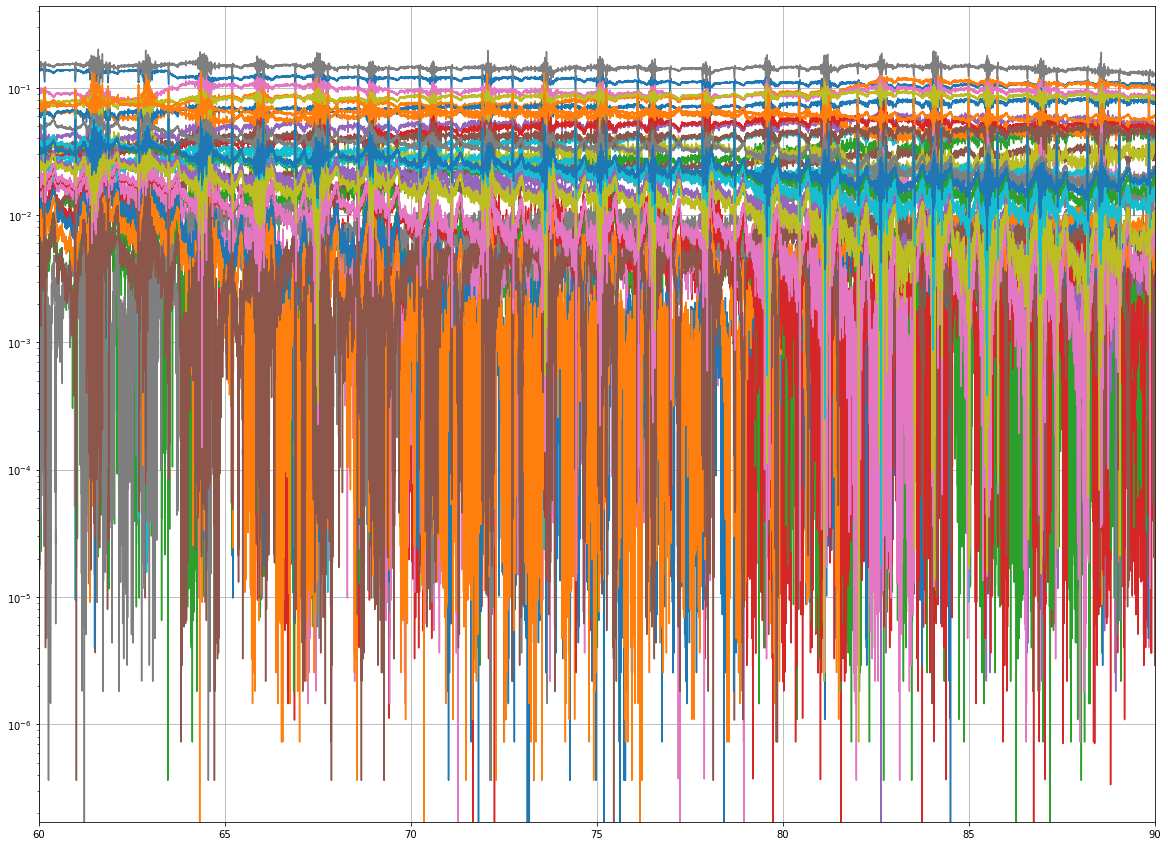

In [11]:
plt.figure(figsize=(20, 15))
_ = plt.plot(np.arange(len(tmp))/4000.0, np.abs(tmp - np.median(tmp, axis=0))/50000 + 0*np.arange(32))
plt.xlim(60, 90)
plt.yscale('log')
plt.grid()

In [4]:
data = get_data(expt_names, new_layout)
print(data.dtype)
#data_test = get_data(expt_names_test, six_finger_layout)
# data['key_label'][np.where(data['key_label'] == ord('a'))] = 0
# data['key_label'][np.where(data['key_label'] == ord('s'))] = 0
# data['key_label'][np.where(data['key_label'] == ord('d'))] = 1
# data['key_label'][np.where(data['key_label'] == ord('f'))] = 1
# full_dataset.balance_classes(time_shift=False, add_noise=True)

['h', 'b', 'e', 'd', 'g', 'd', 'h', 'a', 'c', 'd', 'c', 'h', 'b', 'c', 'e', 'a', 'h', 'e', 'c', 'c', 'e', 'a', 'c', 'g', 'e', 'h', 'b', 'd', 'd', 'g', 'g', 'c', 'a', 'f', 'a', 'g', 'e', 'h', 'c', 'g', 'g', 'h', 'b', 'g', 'a', 'a', 'f', 'a', 'g', 'h', 'c', 'h', 'd', 'f', 'a', 'h', 'f', 'e', 'f', 'c', 'h', 'd', 'h', 'f', 'e', 'e', 'b', 'c', 'h', 'd', 'a', 'c', 'f', 'e', 'd', 'h', 'd', 'c', 'g', 'c']
Removed 0 out of 800 keypresses.
97, a: 100
98, b: 100
99, c: 100
100, d: 100
101, e: 100
102, f: 100
103, g: 100
104, h: 99
[('full_windows', '<f8', (2000, 64)), ('emg_windows', '<f8', (480, 64)), ('key_label', '<i8')]


In [39]:
print(data['key_label'][:500])

[102 115 102 100 102 103 102 103  97  97  97 115 103 104  97 103  97 115
 102 102 100 104  97  97  97  97 115 103 104 115 104 104 103 104 104 115
 100  97 100 100 100 103 115 102 103 104 104 103 103 102 115  97 100 102
 102 115 102 103 100 100 102 100 100 103 102 102 115 115 115  97 100  97
 115  97 104 115 104 115 103  97  97 102  97 115 115  97 102 102  97 115
 104 102 104  97  97 115 100 115 115 100 100  97 103 115  97 100 102 104
  97  97 115 100 103 103 100 102  97 102  97 103 100 115 100  97 102 104
 102 100 103 100  97 104  97 103 104 103 104 103  97 104 100 100  97 104
 100  97  97 104 100 103 104 104  97 115  97  97 104 100 104 103 102 103
 115 104 115 100 104 103 103  97 102 100 115 103 100 115 104  97 104 100
 115 100 115 115  97  97 115 102 103 100 100 102 115 103 115  97 104 115
 104 103  97 103 115 102 103 104  97  97  97 100 100  97 100 102 104 115
 115  97  97 100  97 100 115 103 115 104 102 103 104 115 115  97 104 102
 103  97 115  97 103 103 104 104  97 100 115 103 10

In [10]:
data.dtype

dtype([('full_windows', '<f8', (4000, 32)), ('emg_windows', '<f8', (480, 32)), ('key_label', '<i8')])

In [ ]:
# emg_data = data_test['emg_windows']
# boxcar = [1]*20
# print(emg_data.shape)
# smoothed_data = np.zeros(((emg_data.shape[0], emg_data.shape[2], emg_data.shape[1])))
# for i in range(emg_data.shape[0]):
#     for j in range(emg_data.shape[2]):
#         smoothed_data[i, j] = np.convolve(np.abs(emg_data[i, :, j]), boxcar, mode='same')

In [ ]:
# smoothed_avg = np.sum(smoothed_data, axis=1)/32

In [ ]:
# y = smoothed_avg
# x = np.arange(0,480)
# for i in range(0, 300):
# #     if(chr(data['key_label'][i]) != 's'):
# #         continue
#     plt.figure(i)
#     #plt.axvline(x=340, color='black')
#     #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
# #     plt.axvline(x=480)
# #     plt.axvline(x=1000-240)
# #     plt.axvline(x=1000+240)
#     for j in range(0,32):
# #         if(j==22):
# #             continue
#         plt.plot(x, y[i, :])
#     plt.show()

In [ ]:
# mapping = {'a': 0, 's': 5, 'd': 1, 'f': 2, 'g': 3, 'h': 4}
# print([mapping[chr(i)] for i in data['key_label'][:50]])

In [ ]:
# y = data['full_windows']
# x = np.arange(0,800*2)
# for i in range(0, 300):
# #     if(chr(data['key_label'][i]) != 's'):
# #         continue
#     plt.figure(i)
#     #plt.axvline(x=340, color='black')
#     #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
#     #plt.axvline(x=1240)
#     #plt.axvline(x=760)
#     #plt.axvline(x=480)
#     #plt.axvline(x=800)
#     #plt.axvline(x=1000)
#     plt.axvline(x=1000)
#     plt.axvline(x=1000-240)
#     plt.axvline(x=1000+240)
#     for j in range(16,32):
# #         if(j==22):
# #             continue
#         plt.plot(x, y[i, :, j])
#     plt.show()

In [ ]:
#DATA VIEWING

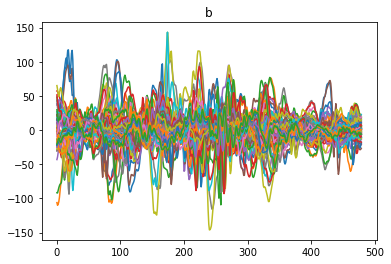

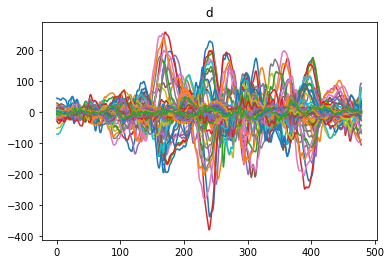

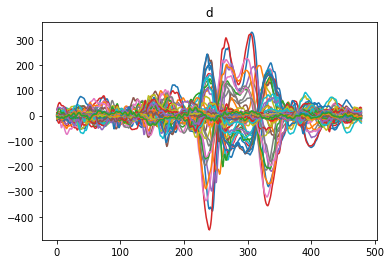

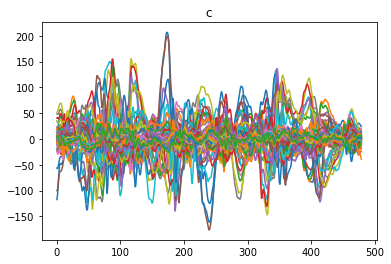

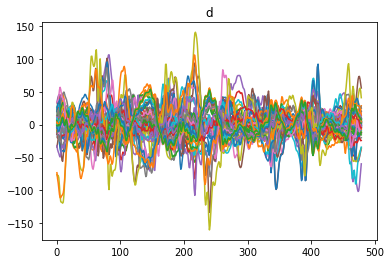

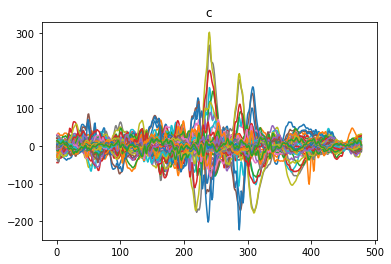

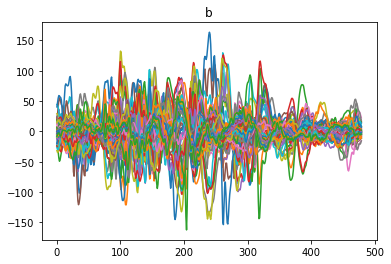

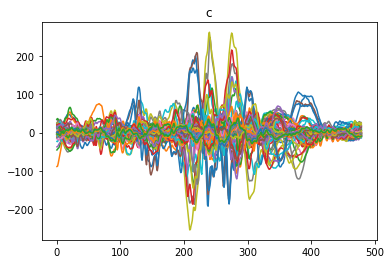

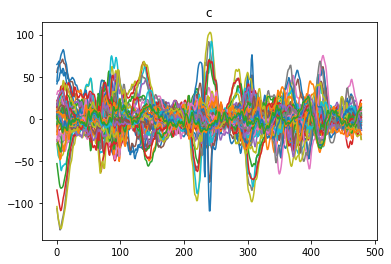

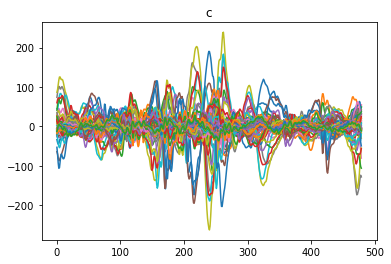

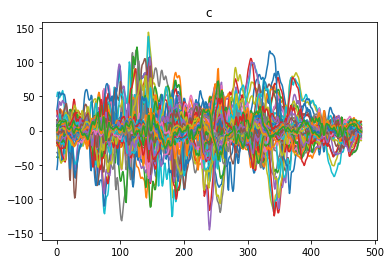

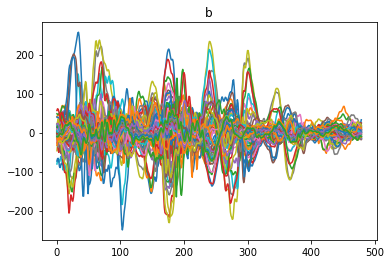

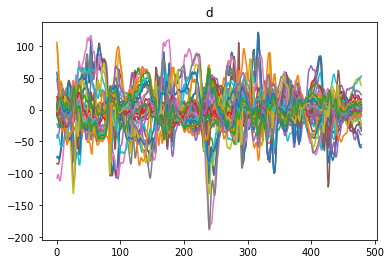

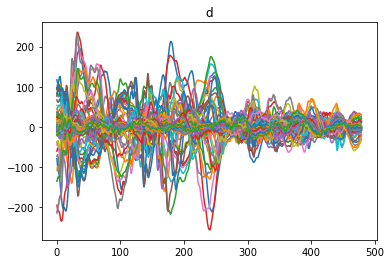

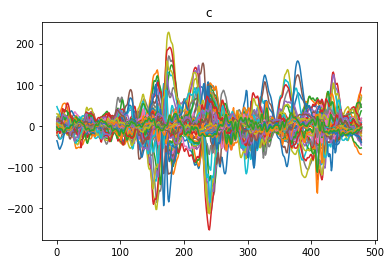

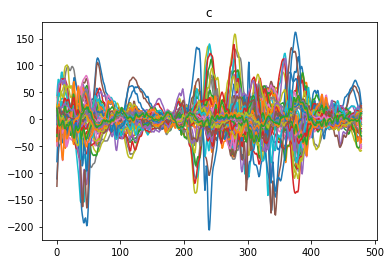

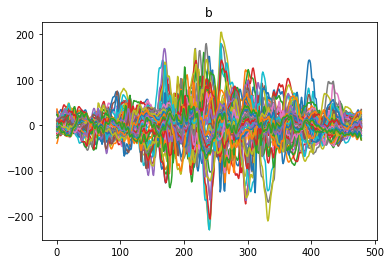

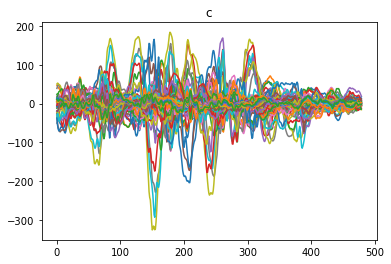

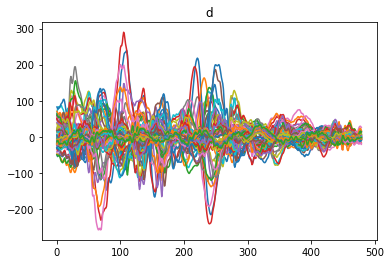

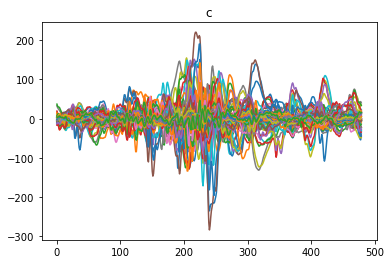

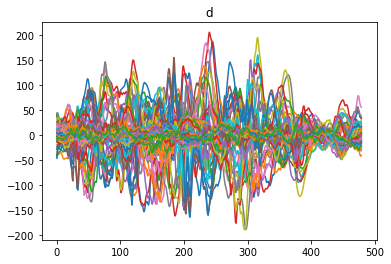

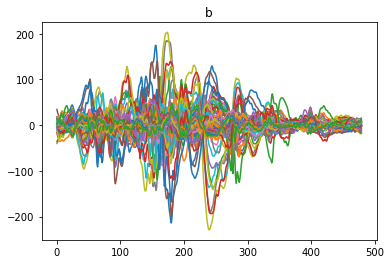

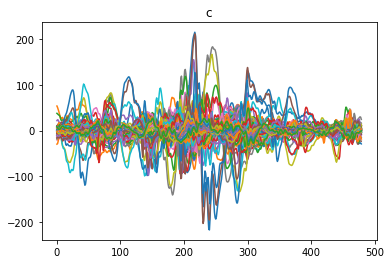

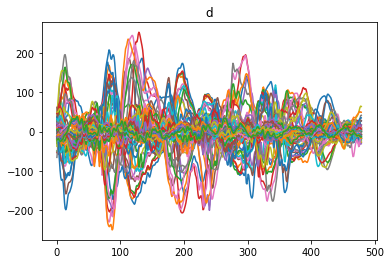

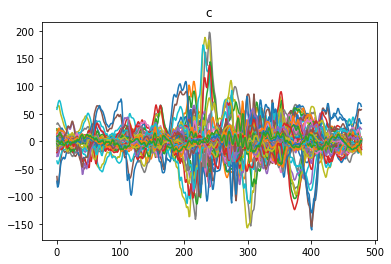

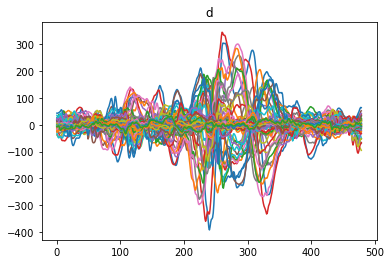

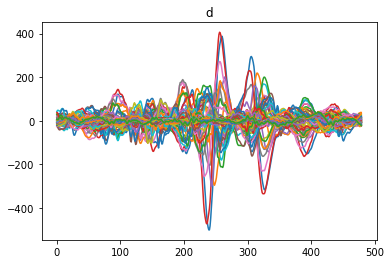

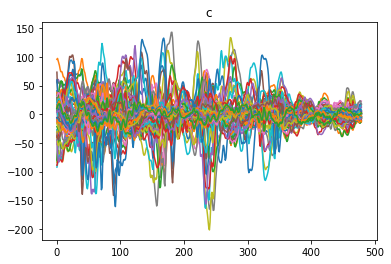

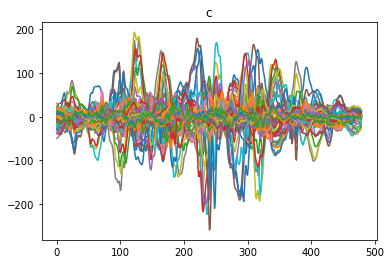

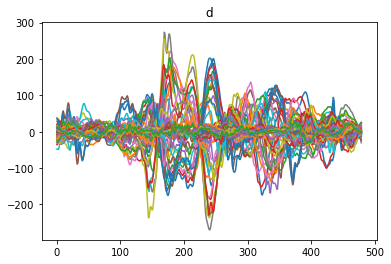

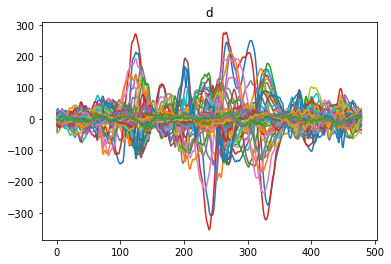

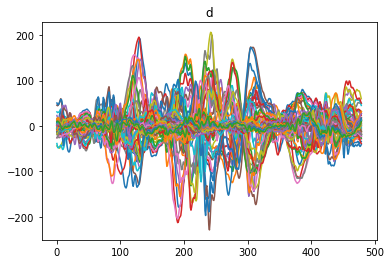

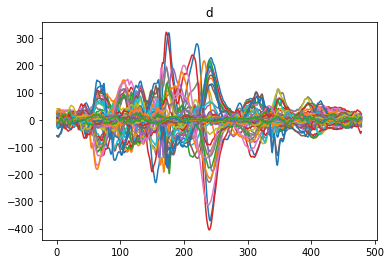

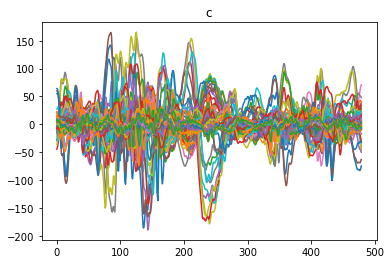

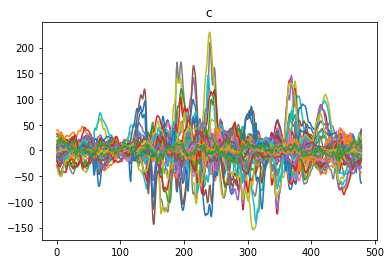

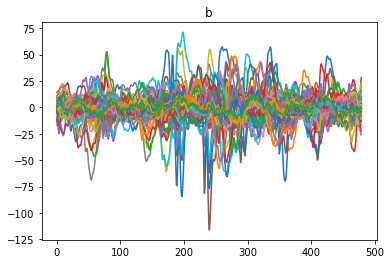

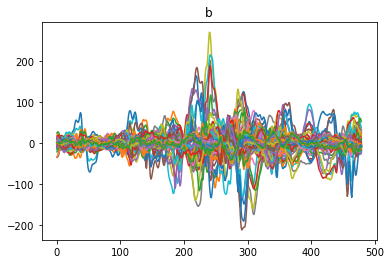

In [7]:
y = data['emg_windows']
x = np.arange(0,480)
for i in range(0, 100):
    if(chr(data['key_label'][i]) not in ['b', 'c', 'd']):
        continue
    plt.figure(i)
    #plt.axvline(x=340, color='black')
    #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
    plt.title(chr(int(data['key_label'][i])))
    #plt.axvline(x=1240)
    #plt.axvline(x=760)
    #plt.axvline(x=480)
    
    #plt.axvline(x=800)
    #plt.axvline(x=1000)
#     plt.axvline(x=2000)
#     plt.axvline(x=1500-240)
#     plt.axvline(x=1500+240)
    for j in range(1, 64):
#         if(j==22):
#             continue
        plt.plot(x, y[i, :, j])
    plt.show()

In [ ]:
z = np.zeros((480, 64))

for i in range(len(data['emg_windows'])):
    if(chr(int(data['key_label'][i])) == 'a'):
        z += data['emg_windows'][i]
plt.plot(z/100)


In [ ]:
# press_probs = [0.4245256, 0.40424472, 0.4732742, 0.45960686, 0.36034346, 0.0056956466, 0.646868, 0.65860033, 0.49513063, 0.6700846, 0.5004693, 0.24690337, 0.05947983, 0.16981317, 0.066428296, 0.294462, 0.31167105, 0.3224459, 0.26402366, 0.14316428, 0.53404427, 0.16661459, 0.21555622, 0.20694734, 0.15845823, 0.30812567, 0.07354336, 0.3636372, 0.2256173, 0.23421372, 0.897329, 0.9999999, 0.8507012, 0.99969935, 0.25037935, 0.1673389, 0.034267742, 0.18198648, 0.89092845, 0.2952422, 0.046150606, 0.51872784, 0.093932025, 0.29779437, 0.11549696, 0.39617056, 0.71209806, 0.36009926, 0.5844185, 0.99846554, 0.9849798, 0.079113364, 0.0057549537, 0.72102165, 0.2471603, 0.71652114, 0.60659367, 0.05758316, 0.16203608, 0.2872308, 0.24603441, 0.47370797, 0.51818585, 0.07076944, 0.18459493, 0.15262412, 0.19298652, 0.08151729, 0.90617216, 0.9491667, 0.78138995, 0.37505096, 0.12859847, 0.16152172, 0.34596545, 0.27549297, 0.002269972, 0.41320133]
# presses = [30, 31, 32, 33, 38, 46, 49, 50, 53, 55, 68, 69, 70]
# #for i in presses:
# #    plt.axvline(x = i, color = 'b')
# length = np.array(press_probs).shape[0]
# x = np.arange(0, length)
# plt.plot(x, press_probs)

In [ ]:
#  6

In [5]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
train_data, val_test_data = train_test_split(data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.8,
#                                             stratify=data['key_label'],
                                            random_state=config['random_seed'])

relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.5,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])


#test_data = data_test


train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=True)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.y = train_data['key_label']
train_dataset.num_chans = train_dataset.X.shape[-1]

train_dataset.print_counts()
#train_dataset.balance_classes(var_factor=3, time_shift=True, add_noise=True)
target = 1000
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id, target_num_samples=target, var_factor=4, time_shift=True, add_noise=False, in_place=True)
# train_dataset.augment_class(0, num_views=3, var_factor=3, time_shift=True, add_noise=True, in_place=True)
# train_dataset.augment_class(1, num_views=6, var_factor=3, time_shift=True, add_noise=True, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

97, a: 80
98, b: 81
99, c: 69
100, d: 80
101, e: 80
102, f: 88
103, g: 79
104, h: 82
97.0, a: 1080
98.0, b: 1081
99.0, c: 1069
100.0, d: 1080
101.0, e: 1080
102.0, f: 1088
103.0, g: 1079
104.0, h: 1082


In [10]:
print(test_data['key_label'])

[ 97 101 103  97  99 100  99 102  99 104 103 104 103  99  98  98  98  97
 100  99  98  99 102 101 103  99  99 101 103  97 103  97  99 103 103 100
 100  98  97  97 104  99 104 102 100 101  99  99 104 101 101  98  99  98
 102 102 101  97 100  98 103 104 104 101  97 104 101 102 103 101 100  98
  97 104  99 103 100  99 100 100]


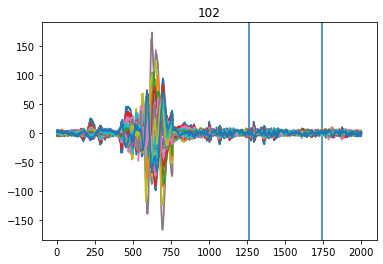

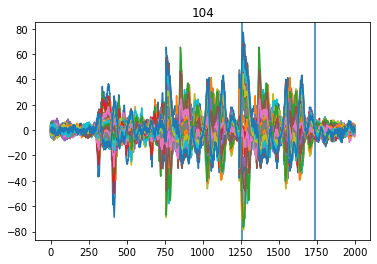

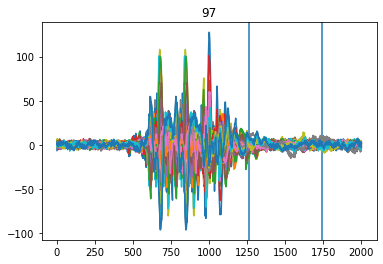

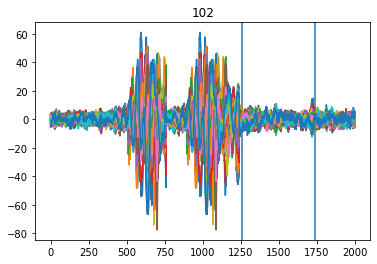

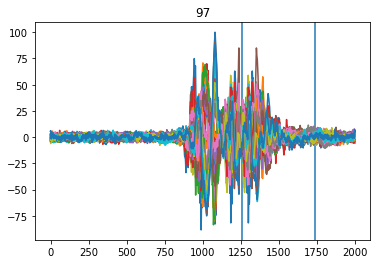

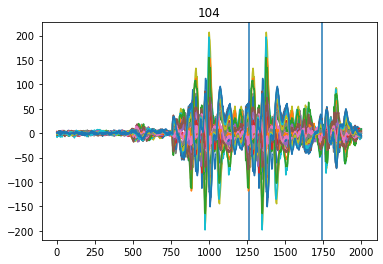

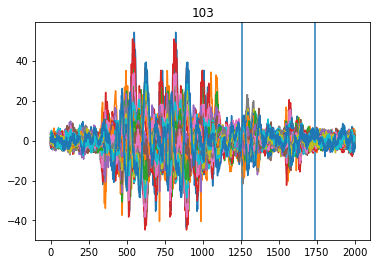

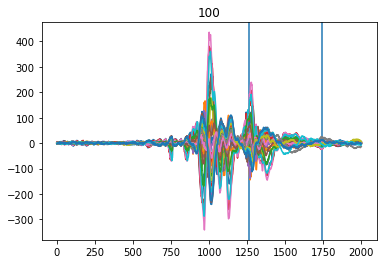

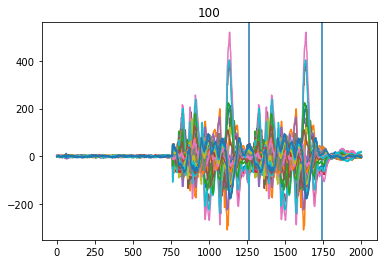

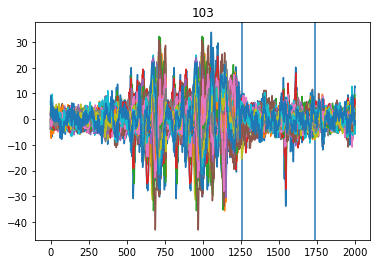

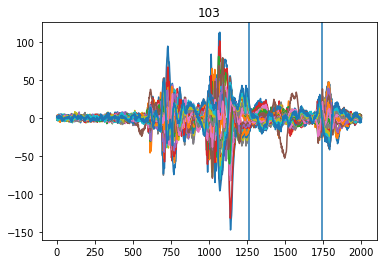

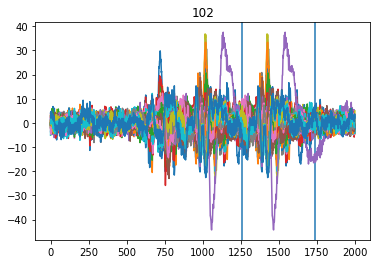

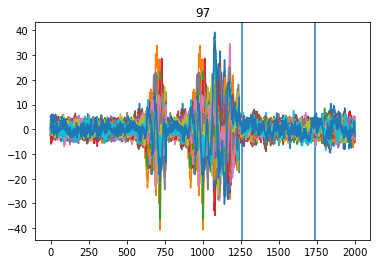

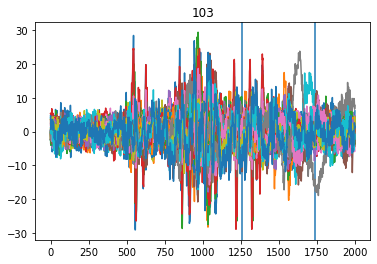

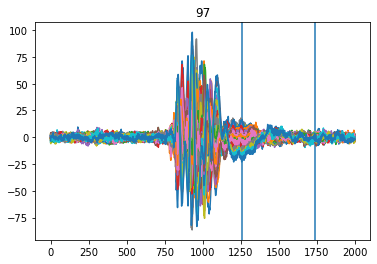

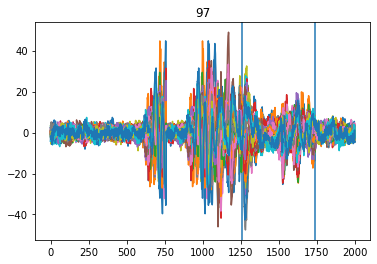

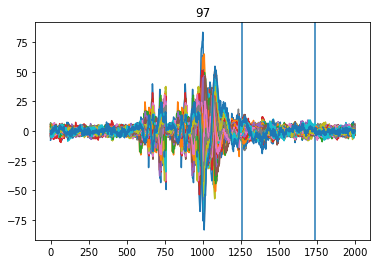

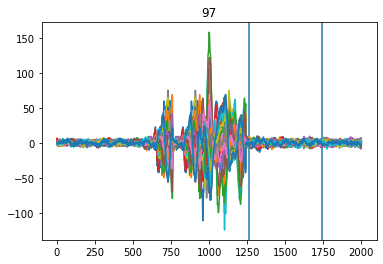

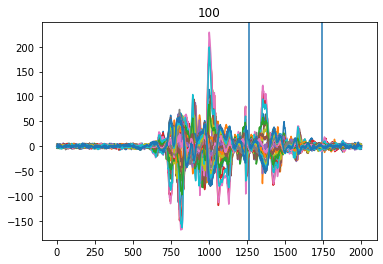

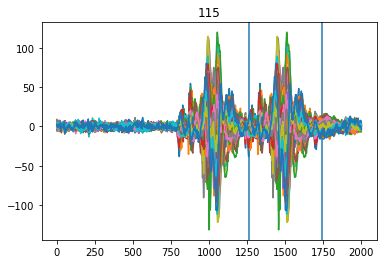

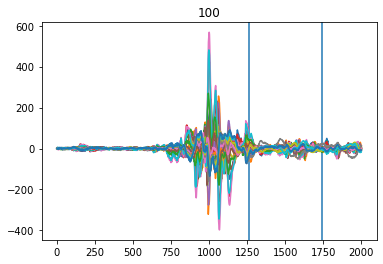

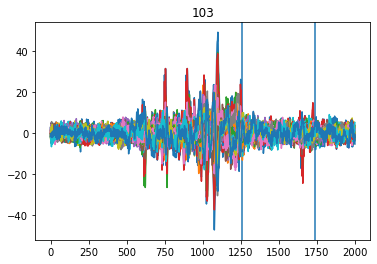

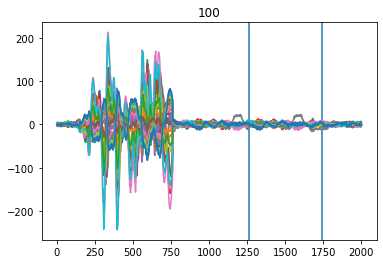

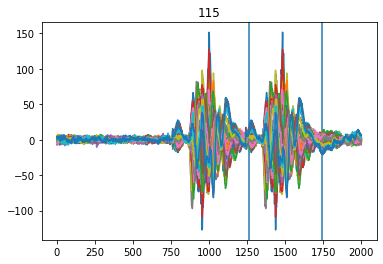

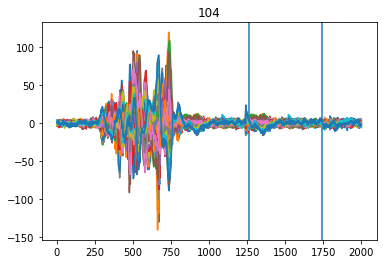

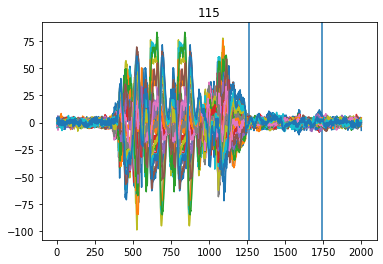

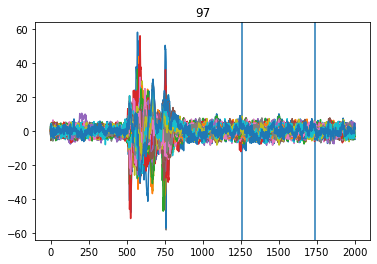

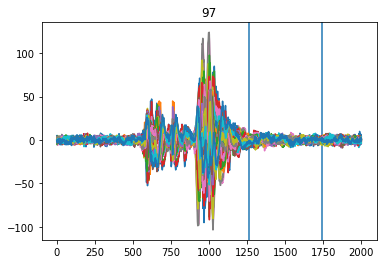

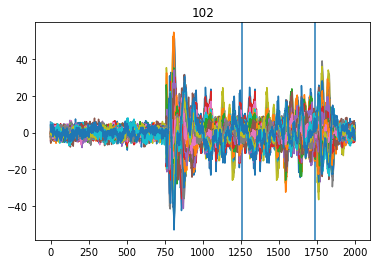

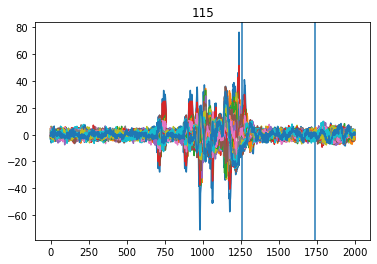

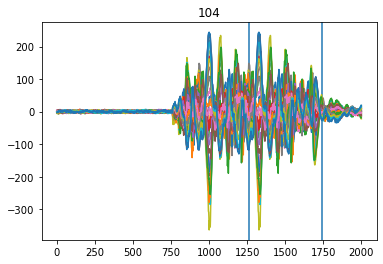

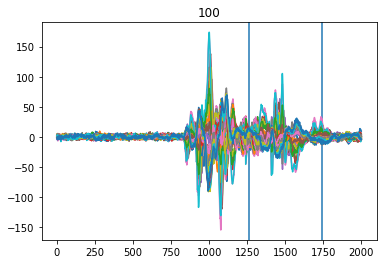

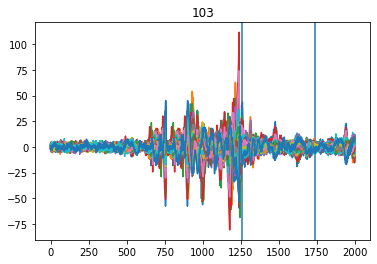

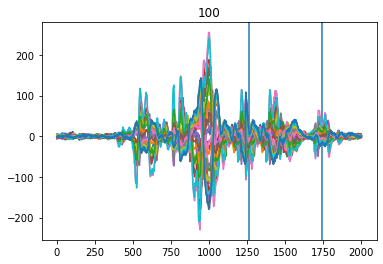

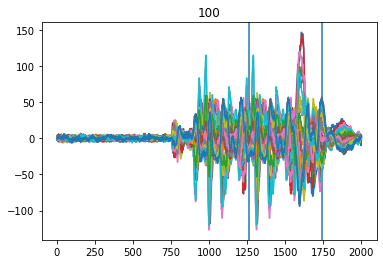

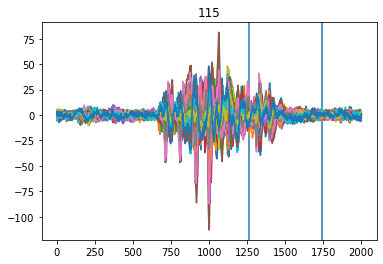

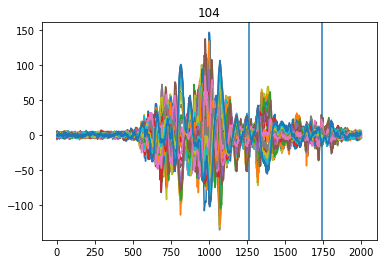

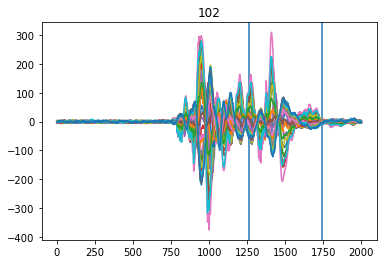

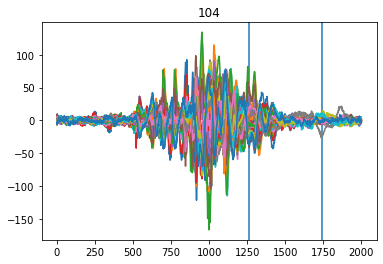

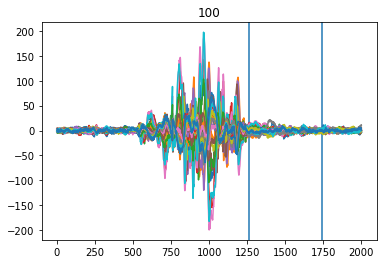

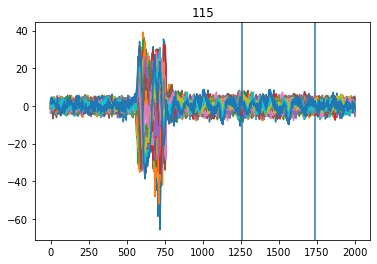

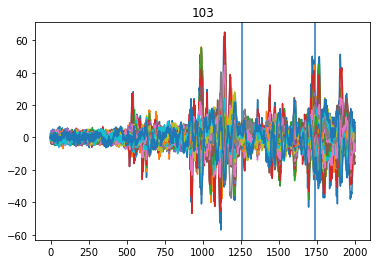

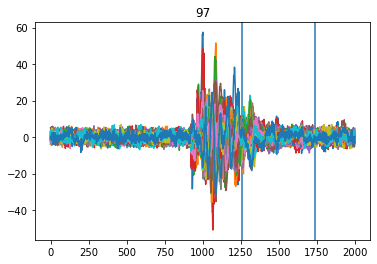

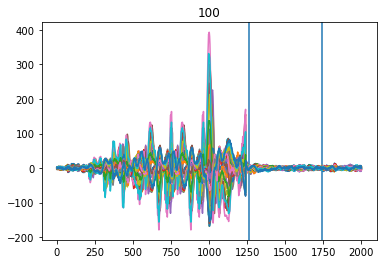

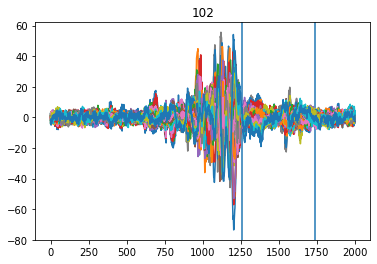

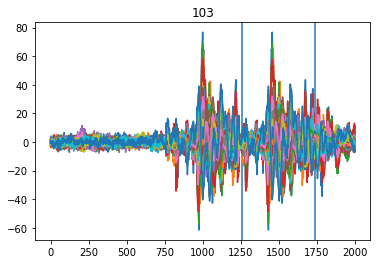

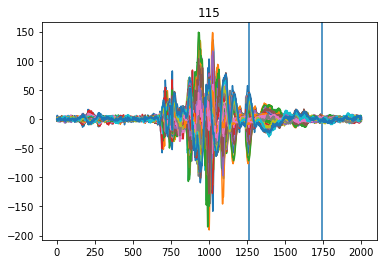

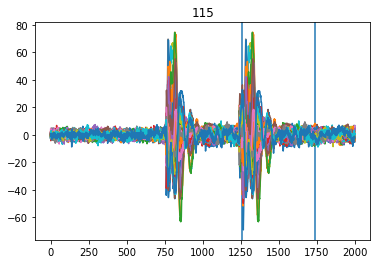

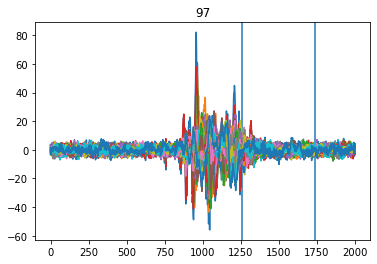

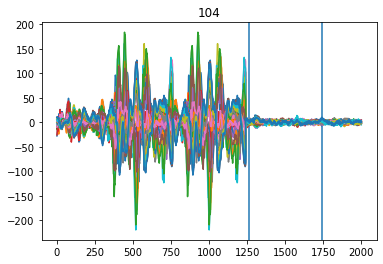

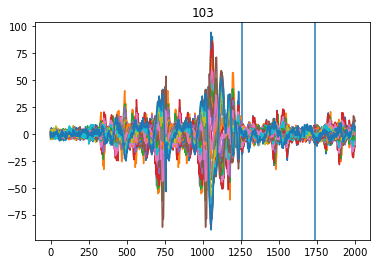

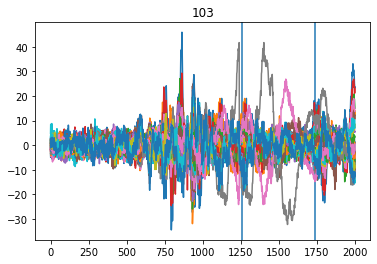

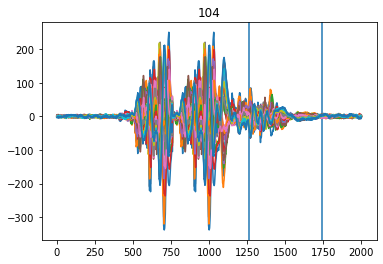

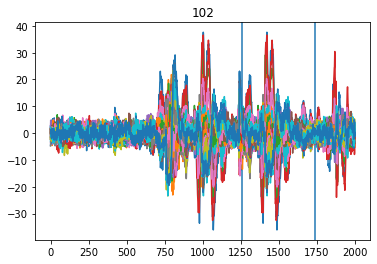

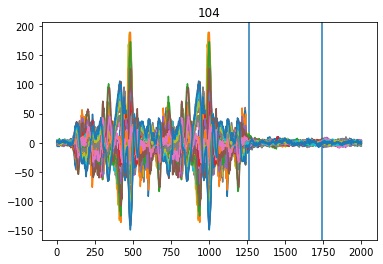

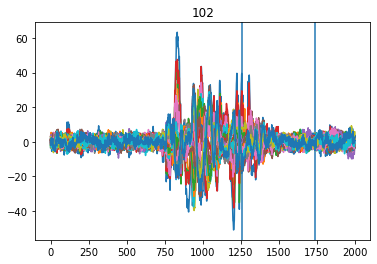

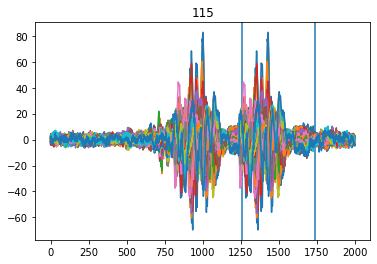

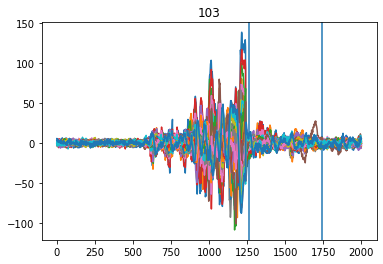

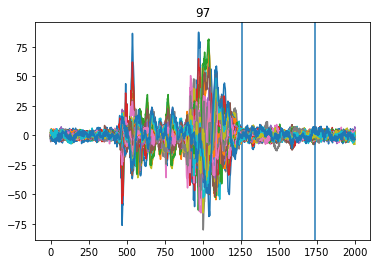

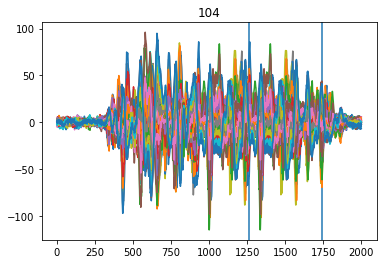

IndexError: index 60 is out of bounds for axis 0 with size 60

<Figure size 432x288 with 0 Axes>

In [27]:
y = test_data['full_windows']
x = np.arange(0,2000)
for i in range(0, 100):
#     if(chr(data['key_label'][i]) != 's'):
#         continue
    plt.figure(i)
    #plt.axvline(x=340, color='black')
    #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
    plt.title(int(test_data['key_label'][i]))
    #plt.axvline(x=1240)
    #plt.axvline(x=760)
    #plt.axvline(x=480)
    
    #plt.axvline(x=800)
    #plt.axvline(x=1000)
#     plt.axvline(x=2000)
    plt.axvline(x=1500-240)
    plt.axvline(x=1500+240)
    for j in range(1, 32):
#         if(j==22):
#             continue
        plt.plot(x, y[i, :, j])
    plt.show()

In [6]:
name = expt_names[0] + "_eightclass"
# name = 'shreyas_testing_combined_balanced_noblanks'

print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
##
##
np.save(test_path, test_data)

config['data']['window_length'] = subwindow_len
config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass
8639 80 80


In [7]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]

system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
    run=True
    )

Seed set to 4995


/home/john/emg_decoder/data/processed/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass_test.npy


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/john/emg_decoder/models/derek_table_

/home/john/emg_decoder/data/processed/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass_test.npy


2024-07-30 17:24:34.468026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 17:24:34.570546: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | loss  | CrossEntropyLoss   | 0     
1 | acc   | MulticlassAccuracy | 0     
2 | model | KeyClassifier      | 147 K 
---------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     T

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [8]:
expt = Experiment(system_type, experiment_dir, version=0)
expt.list_checkpoints()

Versions: ['0'] available, loading version 0...


['bell-epoch=02-val_loss=0.38.ckpt',
 'bell-epoch=08-val_loss=0.39.ckpt',
 'bell-epoch=16-val_loss=0.38.ckpt',
 'last.ckpt',
 'bell-epoch=07-val_loss=0.38.ckpt',
 'bell-epoch=06-val_loss=0.26.ckpt']

In [12]:
system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=06-val_loss=0.26.ckpt")
trainer.test(system)
out = trainer.predict(system)

/home/john/emg_decoder/data/processed/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass_test.npy
/home/john/emg_decoder/data/processed/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.887499988079071
        test_loss           1.0474703311920166
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [35]:
#bell epoch 2

system.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 4.3235e-02,  3.4917e-01, -4.9108e-04, -2.3902e-01, -1.1697e-02,
                          2.3788e-01,  1.8098e-02, -2.6764e-01, -1.3510e-01]]],
              
              
                      [[[ 6.3175e-02,  8.2659e-02, -3.8160e-02,  1.3896e-01, -2.5819e-01,
                          1.3821e-01, -2.9031e-01, -6.0726e-02,  2.0640e-01]]],
              
              
                      [[[ 2.1767e-01, -3.4819e-02,  8.2045e-02, -8.1226e-03, -2.4332e-01,
                         -8.5328e-02, -1.9031e-01, -1.2189e-01,  2.5061e-01]]],
              
              
                      [[[-1.5336e-02,  7.2527e-02, -2.1740e-02, -1.8347e-01,  7.6881e-02,
                          3.3723e-01, -2.3147e-01, -1.9336e-02, -2.6485e-02]]],
              
              
                      [[[ 3.9942e-02,  1.3333e-01,  1.0975e-01,  2.5784e-01,  1.9595e-01,
                         -3.3994e-01, -2.5555e-01, -6.4668e-02,  

In [51]:
#bell epoch 2 new run 3

system.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 0.0440,  0.3469, -0.0043, -0.2415, -0.0120,  0.2385,  0.0175,
                         -0.2699, -0.1380]]],
              
              
                      [[[ 0.0678,  0.0876, -0.0320,  0.1469, -0.2499,  0.1461, -0.2827,
                         -0.0527,  0.2131]]],
              
              
                      [[[ 0.2101, -0.0419,  0.0768, -0.0112, -0.2445, -0.0856, -0.1913,
                         -0.1246,  0.2464]]],
              
              
                      [[[-0.0096,  0.0783, -0.0162, -0.1786,  0.0800,  0.3390, -0.2288,
                         -0.0133, -0.0174]]],
              
              
                      [[[ 0.0442,  0.1368,  0.1121,  0.2597,  0.1983, -0.3360, -0.2504,
                         -0.0591,  0.0118]]],
              
              
                      [[[ 0.1019,  0.2092, -0.2549,  0.0189,  0.1955,  0.1135,  0.2811,
                         -0.2267,  0.1343]]],
 

In [33]:
#bell epoch 1

system.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 4.3235e-02,  3.4917e-01, -4.9108e-04, -2.3902e-01, -1.1697e-02,
                          2.3788e-01,  1.8098e-02, -2.6764e-01, -1.3510e-01]]],
              
              
                      [[[ 6.3175e-02,  8.2659e-02, -3.8160e-02,  1.3896e-01, -2.5819e-01,
                          1.3821e-01, -2.9031e-01, -6.0726e-02,  2.0640e-01]]],
              
              
                      [[[ 2.1767e-01, -3.4819e-02,  8.2045e-02, -8.1226e-03, -2.4332e-01,
                         -8.5328e-02, -1.9031e-01, -1.2189e-01,  2.5061e-01]]],
              
              
                      [[[-1.5336e-02,  7.2527e-02, -2.1740e-02, -1.8347e-01,  7.6881e-02,
                          3.3723e-01, -2.3147e-01, -1.9336e-02, -2.6485e-02]]],
              
              
                      [[[ 3.9942e-02,  1.3333e-01,  1.0975e-01,  2.5784e-01,  1.9595e-01,
                         -3.3994e-01, -2.5555e-01, -6.4668e-02,  

In [40]:
#bell epoch 1 new run

system.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 3.6159e-02,  3.4344e-01, -7.6051e-03, -2.4591e-01, -1.4491e-02,
                          2.3874e-01,  1.6395e-02, -2.7510e-01, -1.4385e-01]]],
              
              
                      [[[ 6.2894e-02,  8.1898e-02, -3.7864e-02,  1.4261e-01, -2.5274e-01,
                          1.4497e-01, -2.8491e-01, -5.3855e-02,  2.1343e-01]]],
              
              
                      [[[ 2.1957e-01, -3.8140e-02,  7.6145e-02, -1.4647e-02, -2.4869e-01,
                         -8.8421e-02, -1.9206e-01, -1.2441e-01,  2.4496e-01]]],
              
              
                      [[[-1.1560e-02,  8.1137e-02, -1.4925e-02, -1.8378e-01,  6.8669e-02,
                          3.2761e-01, -2.3782e-01, -1.7408e-02, -2.1278e-02]]],
              
              
                      [[[ 4.6484e-02,  1.3600e-01,  1.1136e-01,  2.5946e-01,  1.9599e-01,
                         -3.4189e-01, -2.5657e-01, -6.5148e-02,  

In [46]:
#bell epoch 1 new run 2

system.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 3.6555e-02,  3.4399e-01, -7.5093e-03, -2.4638e-01, -1.5254e-02,
                          2.3797e-01,  1.5758e-02, -2.7558e-01, -1.4399e-01]]],
              
              
                      [[[ 6.3413e-02,  8.1997e-02, -3.7795e-02,  1.4316e-01, -2.5181e-01,
                          1.4580e-01, -2.8424e-01, -5.2909e-02,  2.1483e-01]]],
              
              
                      [[[ 2.1996e-01, -3.7761e-02,  7.6429e-02, -1.4665e-02, -2.4908e-01,
                         -8.8890e-02, -1.9232e-01, -1.2453e-01,  2.4494e-01]]],
              
              
                      [[[-1.1587e-02,  8.1150e-02, -1.4671e-02, -1.8345e-01,  6.8725e-02,
                          3.2758e-01, -2.3759e-01, -1.6833e-02, -2.0585e-02]]],
              
              
                      [[[ 4.4818e-02,  1.3464e-01,  1.1055e-01,  2.5917e-01,  1.9606e-01,
                         -3.4164e-01, -2.5620e-01, -6.4739e-02,  

In [30]:
system.config
new_test_path = processed_data_dir + name + "_newtest.npy"
np.save(new_test_path, data_test)
config['data']['test_path'] = new_test_path


In [31]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]
system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
    run=False
    )

Global seed set to 4995


/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_newtest.npy


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
system.config['data']['test_path'] = new_test_path

In [33]:
system.test_dataset = system.prepare_data()

/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_newtest.npy


In [34]:
system.config

{'name': 'Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified',
 'root_dir': '/home/john/emg_decoder',
 'system': 'KeyDecoder',
 'random_seed': 4995,
 'data': {'train_path': '/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_train.npy',
  'val_path': '/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_val.npy',
  'test_path': '/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_newtest.npy',
  'window_length': 480,
  'train_proportion': 0.8,
  'val_proportion': 0.1,
  'test_proportion': 0.1,
  'train_batch_size': 32,
  'val_batch_size': 32,
  'test_batch_size': 32,
  'num_workers': 4,
  'num_chans': 32,
  'num_classes': 6,
  'classes': [97.0, 100.0, 102.0, 103.0, 104.0, 115.0]},
 'model': {'type': 'KeyNet',
  'loss': 'CrossEntropyLoss',
  'num_temporal_filters': 64,
  'num_spatial_filters': 4,
  'p_d

In [28]:
system.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=14-val_loss=0.10.ckpt")

KeyDecoder(
  (loss): CrossEntropyLoss()
  (acc): MulticlassAccuracy()
  (model): KeyClassifier(
    (model): EEGNet(
      (block1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(1, 9), stride=(1, 1), padding=same)
        (1): Conv2d(64, 256, kernel_size=(32, 1), stride=(1, 1), groups=64)
        (2): ELU(alpha=1.0)
        (3): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        (4): Dropout(p=0.5, inplace=False)
      )
      (block2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(1, 241), stride=(1, 1), padding=same, groups=256)
        (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (2): ELU(alpha=1.0)
        (3): Flatten(start_dim=2, end_dim=-1)
        (4): Linear(in_features=240, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [84]:
testing = np.load(system.config['data']['test_path'])

In [95]:
system.config

{'name': 'Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_testing1',
 'root_dir': '/home/john/emg_decoder',
 'system': 'KeyDecoder',
 'random_seed': 4995,
 'data': {'train_path': '/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_testing1_train.npy',
  'val_path': '/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_testing1_val.npy',
  'test_path': '/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_testing1_newtest.npy',
  'window_length': 480,
  'train_proportion': 0.8,
  'val_proportion': 0.1,
  'test_proportion': 0.1,
  'train_batch_size': 32,
  'val_batch_size': 32,
  'test_batch_size': 32,
  'num_workers': 4,
  'num_chans': 32,
  'num_classes': 6,
  'classes': [97.0, 100.0, 102.0, 103.0, 104.0, 115.0]},
 'model': {'type': 'KeyNet',
  'loss': 'CrossEntropyLoss',
  'num_temporal_filters': 64,
  'num_spatial_filters': 4,
  'p_dropout': 0.5,
  'avgpool_factor': 2},
 'optimizer': {'learni

In [111]:
val = np.load(system.config['data']['val_path'])
test = np.load(system.config['data']['test_path'])

In [112]:
print(val.dtype, test.dtype)


[('full_windows', '<f8', (4000, 32)), ('emg_windows', '<f8', (480, 32)), ('key_label', '<i8')] [('full_windows', '<f8', (4000, 32)), ('emg_windows', '<f8', (480, 32)), ('key_label', '<i8')]


In [10]:
system.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=19-val_loss=0.27.ckpt")
trainer.test(system)
out = trainer.predict(system)

TypeError: The classmethod `KeyDecoder.load_from_checkpoint` cannot be called on an instance. Please call it on the class type and make sure the return value is used.

In [32]:
trainer.validate(system)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1041666641831398
        val_loss            3.1913115978240967
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 3.1913115978240967, 'val_acc': 0.1041666641831398}]

In [13]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
# print(Xs)
# preds = np.hstack([torch.round(torch.nn.functional.sigmoid(a[0])) for a in out])
# print(preds)

(80, 8) (80,)


In [14]:
print(ys)
print(preds)


[0 4 6 0 2 3 2 5 2 7 6 7 6 2 1 1 1 0 3 2 1 2 5 4 6 2 2 4 6 0 6 0 2 6 6 3 3
 1 0 0 7 2 7 5 3 4 2 2 7 4 4 1 2 1 5 5 4 0 3 1 6 7 7 4 0 7 4 5 6 4 3 1 0 7
 2 6 3 2 3 3]
[0 4 6 6 2 3 2 5 2 7 0 7 6 2 1 1 1 0 3 2 1 2 5 4 6 2 2 4 6 0 4 0 2 6 6 7 3
 1 0 0 5 3 0 5 3 6 2 2 7 4 4 1 2 1 5 5 4 0 3 1 6 7 7 4 0 7 4 5 6 4 3 1 0 7
 2 0 3 2 3 3]


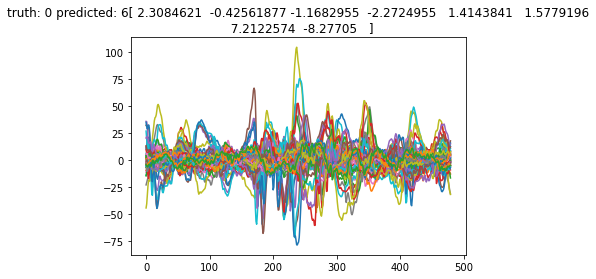

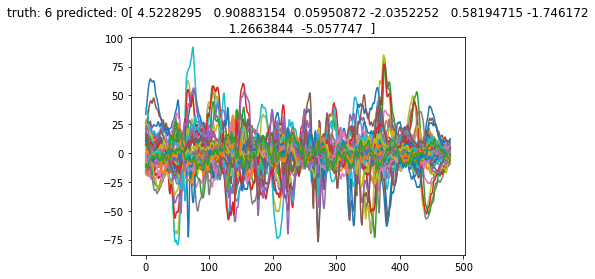

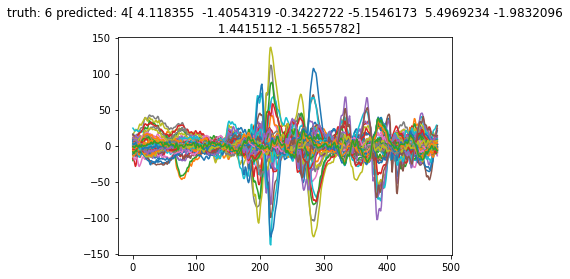

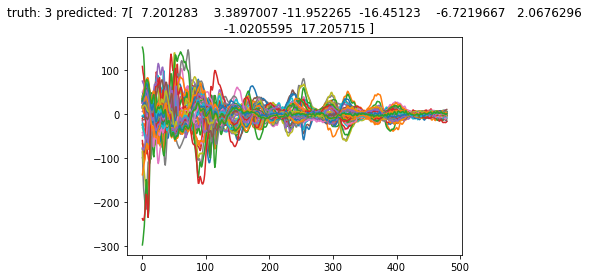

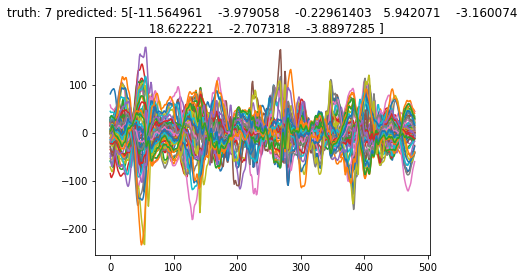

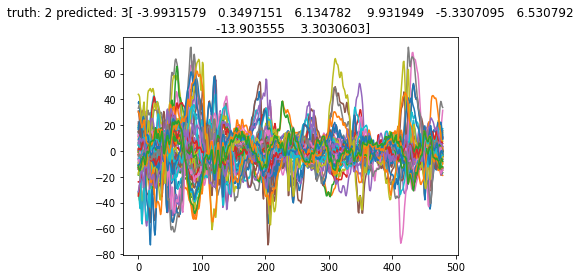

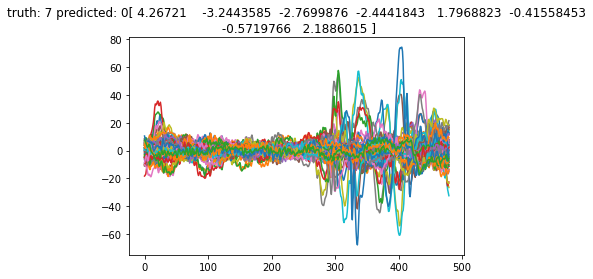

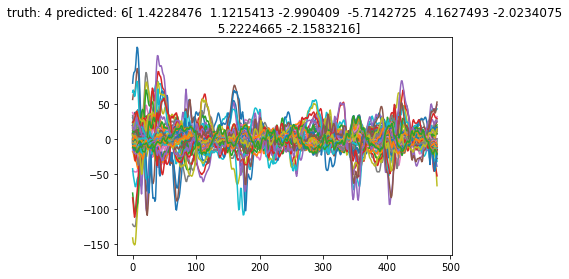

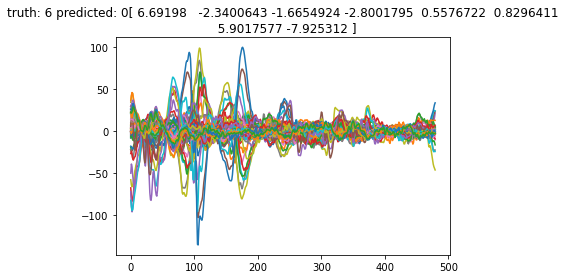

In [15]:
x = np.arange(0, 480)
y = test_data['emg_windows']
for i in range(len(ys)):
    if(ys[i] != preds[i]):
        plt.figure(i)
        #plt.axvline(x=340, color='black')
        #plt.axvline(x=660, color='black')

    #     plt.title(chr(int(data['key_label'][i])))
        temp = "truth: " + str(ys[i]) + " predicted: " + str(preds[i]) + str(Xs[i])
        plt.title(temp)
        #plt.axvline(x=1240)
        #plt.axvline(x=760)
        #plt.axvline(x=480)

        #plt.axvline(x=800)
        #plt.axvline(x=1000)
    #     plt.axvline(x=2000)
    #         plt.axvline(x=1500-240)
    #         plt.axvline(x=1500+240)
        for j in range(1, 64):
    #         if(j==22):
    #             continue
            plt.plot(x, y[i, :, j])
        plt.show()

In [16]:
typing_test_layout = [65505, 'a', 'w', 'd', ' ', 'j', 'i', 'o', ';']
asciis = [ord(ch) if type(ch) == str else ch for ch in new_layout]
print(asciis)
idxs = np.argsort(asciis)
# idxs = [0, 2, 3, 4, 5, 1]
print(np.argsort(asciis))
print(np.unique(ys))
reord_ys = np.array([idxs[i] for i in ys])
reord_preds = np.array([idxs[i] for i in preds])
print(reord_ys)
print(preds)

[97, 98, 99, 100, 101, 102, 103, 104]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 4 6 0 2 3 2 5 2 7 6 7 6 2 1 1 1 0 3 2 1 2 5 4 6 2 2 4 6 0 6 0 2 6 6 3 3
 1 0 0 7 2 7 5 3 4 2 2 7 4 4 1 2 1 5 5 4 0 3 1 6 7 7 4 0 7 4 5 6 4 3 1 0 7
 2 6 3 2 3 3]
[0 4 6 6 2 3 2 5 2 7 0 7 6 2 1 1 1 0 3 2 1 2 5 4 6 2 2 4 6 0 4 0 2 6 6 7 3
 1 0 0 5 3 0 5 3 6 2 2 7 4 4 1 2 1 5 5 4 0 3 1 6 7 7 4 0 7 4 5 6 4 3 1 0 7
 2 0 3 2 3 3]


In [17]:
ys

array([0, 4, 6, 0, 2, 3, 2, 5, 2, 7, 6, 7, 6, 2, 1, 1, 1, 0, 3, 2, 1, 2,
       5, 4, 6, 2, 2, 4, 6, 0, 6, 0, 2, 6, 6, 3, 3, 1, 0, 0, 7, 2, 7, 5,
       3, 4, 2, 2, 7, 4, 4, 1, 2, 1, 5, 5, 4, 0, 3, 1, 6, 7, 7, 4, 0, 7,
       4, 5, 6, 4, 3, 1, 0, 7, 2, 6, 3, 2, 3, 3])

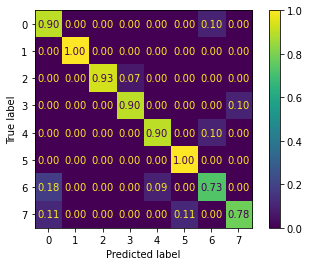

In [18]:
disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f',
                                               )


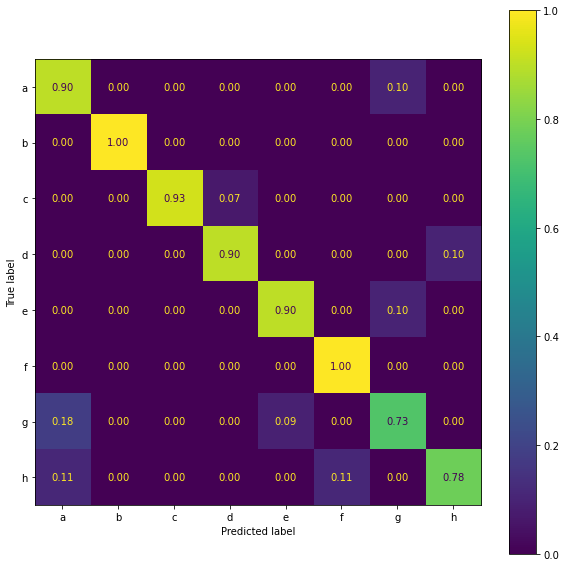

In [19]:
plt.rcParams["figure.figsize"] = (10, 10)
# classes = system.classes
# print(classes)
classes = [ord('a'), ord('b'), ord('c'), ord('d'), ord('e'), ord('f'), ord('g'), ord('h')]
#classes = [ord("\x00"), ord('q'), ord('a'), ord('z'), ord('w'), ord('s'), ord('x'), ord('e'), ord('d'), ord('c'), ord('r'), ord('f'), ord('v'), ord('t'), ord('g'), ord('b')]
labels = [chr(int(c)) for c in classes]
disp = ConfusionMatrixDisplay.from_predictions(reord_ys, reord_preds, normalize='true', values_format='.2f',
                                               display_labels=[chr(int(i)) if i != 65505 else 'shift' for i in classes])


In [21]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")

In [22]:
print(f"{experiment_dir}/models/{config['name']}.pt")

/home/john/emg_decoder/models/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass/models/derek_table_2024-07-30-1622_Rhythm-Game-Typing-Task_eightclass.pt


In [37]:
experiment_dir

'/home/john/emg_decoder/models/nima_table_2024-07-23-1508_Rhythm-Game-Typing-Task_binary'

In [ ]:
f"{config['name']}.pt"

In [11]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]
system_test, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
    run=False
    )

Global seed set to 4995


/home/john/emg_decoder/data/processed/Jacob_2024-04-25-1303_Rhythm-Game-Typing-Task_bin1_test.npy


/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
expt = Experiment(system_type, '/home/john/emg_decoder/models/Jacob_2024-04-25-1303_Rhythm-Game-Typing-Task_class1/', version=0)
expt.list_checkpoints()

Versions: ['0'] available, loading version 0...


['bell-epoch=04-val_loss=0.24.ckpt',
 'bell-epoch=03-val_loss=0.20.ckpt',
 'Jacob_2024-04-25-1303_Rhythm-Game-Typing-Task_class1.pt',
 'bell-epoch=01-val_loss=0.25.ckpt',
 'bell-epoch=09-val_loss=0.27.ckpt',
 'last.ckpt',
 'bell-epoch=06-val_loss=0.30.ckpt']

In [43]:
model_new = system_test.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=34-val_loss=0.00.ckpt")

/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_test.npy


In [16]:
model1 = system_test.load_from_checkpoint('/home/john/emg_decoder/models/Jacob_2024-04-25-1303_Rhythm-Game-Typing-Task_class1/models/bell-epoch=03-val_loss=0.20.ckpt')
model1.state_dict()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [44]:
trainer.test(model_new)
out = trainer.predict(model_new)

/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_test.npy


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7966101765632629
        test_loss            4.653861045837402
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_notstratified_test.npy


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [77]:


# model1.test_path = test_path
# np.save('/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_6finger_test.npy', data_test)
# _, _, new_test_data = model1.prepare_data()

# print(len(new_test_data))
# model1.test_dataset = new_test_data
# model1.eval()

In [78]:
trainer.test(model1)
out = trainer.predict(system)

/home/john/emg_decoder/data/processed/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_check_test.npy


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7118644118309021
        test_loss            4.180304527282715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


NameError: name 'system' is not defined

In [10]:
model2 = system_test.load_from_checkpoint('/home/john/emg_decoder/models/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_test6/models/bell-epoch=02-val_loss=0.14.ckpt')
model2.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 4.2495e-02,  3.4577e-01, -5.0844e-03, -2.4202e-01, -1.2332e-02,
                          2.3848e-01,  1.7657e-02, -2.6972e-01, -1.3765e-01]]],
              
              
                      [[[ 6.6703e-02,  8.6737e-02, -3.2826e-02,  1.4624e-01, -2.5003e-01,
                          1.4656e-01, -2.8182e-01, -5.1827e-02,  2.1348e-01]]],
              
              
                      [[[ 2.1025e-01, -4.1981e-02,  7.6707e-02, -1.1054e-02, -2.4412e-01,
                         -8.5171e-02, -1.9094e-01, -1.2454e-01,  2.4610e-01]]],
              
              
                      [[[-9.7665e-03,  7.7972e-02, -1.6794e-02, -1.7972e-01,  7.8536e-02,
                          3.3758e-01, -2.2981e-01, -1.3861e-02, -1.7870e-02]]],
              
              
                      [[[ 4.1778e-02,  1.3431e-01,  1.0965e-01,  2.5727e-01,  1.9605e-01,
                         -3.3745e-01, -2.5093e-01, -5.9426e-02,  

In [29]:
trainer.test(model1)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8305084705352783
        test_loss           0.5199470520019531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5199470520019531, 'test_acc': 0.8305084705352783}]

In [15]:
model0 = system_test.load_from_checkpoint('/home/john/emg_decoder/models/Jacob_2024-04-03-1425_Rhythm-Game-Typing-Task_bigwindow_test6/models/bell-epoch=00-val_loss=0.52.ckpt')
model0.state_dict()

OrderedDict([('model.model.block1.0.weight',
              tensor([[[[ 2.7196e-02,  3.3738e-01, -1.4112e-02, -2.5315e-01, -2.0409e-02,
                          2.3445e-01,  1.2575e-02, -2.7793e-01, -1.4388e-01]]],
              
              
                      [[[ 6.1919e-02,  8.2007e-02, -3.7856e-02,  1.4304e-01, -2.5323e-01,
                          1.4355e-01, -2.8788e-01, -5.5894e-02,  2.1438e-01]]],
              
              
                      [[[ 2.2424e-01, -3.7355e-02,  7.2877e-02, -2.1449e-02, -2.5705e-01,
                         -9.5974e-02, -1.9830e-01, -1.2903e-01,  2.4171e-01]]],
              
              
                      [[[-3.5777e-03,  9.0831e-02, -7.4016e-03, -1.8074e-01,  6.6796e-02,
                          3.2392e-01, -2.4077e-01, -1.5154e-02, -1.5122e-02]]],
              
              
                      [[[ 5.1850e-02,  1.3861e-01,  1.1456e-01,  2.6588e-01,  2.0660e-01,
                         -3.2790e-01, -2.4073e-01, -4.9177e-02,  

In [20]:
trainer.test(model0)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6610169410705566
        test_loss            0.918298065662384
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.918298065662384, 'test_acc': 0.6610169410705566}]

In [57]:
indices = np.argwhere(data['key_label'] == 97)

80

In [22]:
with open('/home/john/emg_decoder/out.txt', 'rb') as f:
    a = np.load(f)

In [23]:
a.shape

(16, 256)

In [24]:
print(a)

[[-6.5986037 -1.552799  -1.7645528 ... -1.552799  -1.5528052 -1.552799 ]
 [-1.552799  -1.552799  -1.552799  ... -4.851266  -1.552799  -1.552799 ]
 [-1.5540385 -1.552799  -1.407321  ... -1.551925  -1.552799  -1.5527983]
 ...
 [50.35956   -1.552799  -1.552799  ...  1.7820315 -1.4255717 -1.552799 ]
 [-1.5527623 -1.5528021 -1.552799  ... -1.2959251 -1.5508149 -1.5632708]
 [-1.5528183 -1.7855465 -1.552799  ... -1.5529385 -1.5494261 -1.552799 ]]


In [20]:
b.shape

(16, 256)

In [21]:
print(b)

[[-6.5986037 -1.552799  -1.7645528 ... -1.552799  -1.5528052 -1.552799 ]
 [-1.552799  -1.552799  -1.552799  ... -4.851266  -1.552799  -1.552799 ]
 [-1.5540385 -1.552799  -1.407321  ... -1.551925  -1.552799  -1.5527983]
 ...
 [50.35956   -1.552799  -1.552799  ...  1.7820315 -1.4255717 -1.552799 ]
 [-1.5527623 -1.5528021 -1.552799  ... -1.2959251 -1.5508149 -1.5632708]
 [-1.5528183 -1.7855465 -1.552799  ... -1.5529385 -1.5494261 -1.552799 ]]


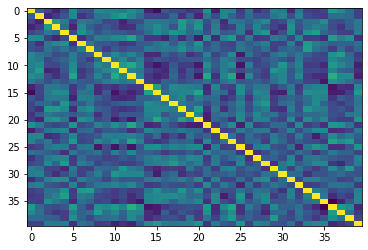

In [35]:
plt.imshow(np.corrcoef(data['emg_windows'].reshape((479,-1))),aspect='auto', interpolation='None')

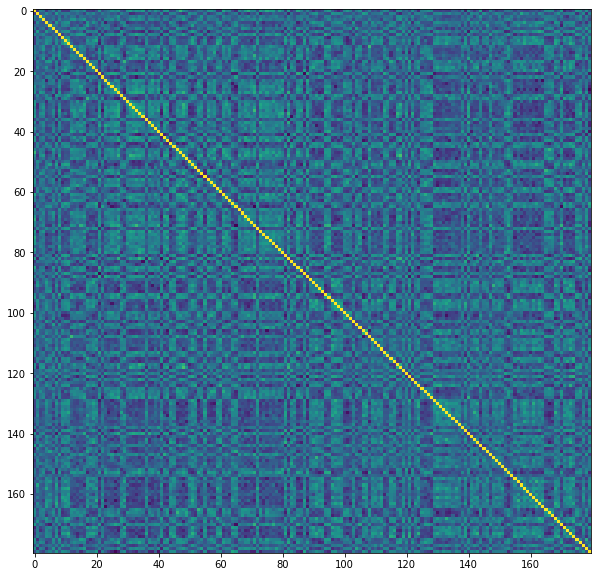

In [99]:
blah = np.concatenate((data['emg_windows'], data_test['emg_windows'])).reshape((479+59,-1))
plt.imshow(np.corrcoef(blah[boo2]), aspect='auto', interpolation='None')

In [10]:
indices = np.argwhere(data['key_label'] == 104)
indices1 = np.argwhere(data_test['key_label']==104) 

indices2 = np.argwhere(data['key_label'] == 103)
indices3 = np.argwhere(data_test['key_label']==103) 

In [11]:
boo = np.concatenate((indices, indices1+479))
boo2 = np.concatenate((boo, indices2, indices3+479)).squeeze()


In [106]:
from scipy.ndimage import maximum_filter
jah = maximum_filter(data['emg_windows'][0,:,:])
plt.plot(jah)

RuntimeError: no footprint provided

In [1]:

import umap
import umap.plot


ModuleNotFoundError: No module named 'umap'

In [2]:
mapper = umap.UMAP().fit(data['emg_windows'].reshape((479,-1)))
umap.plot.points(mapper)


NameError: name 'umap' is not defined

In [13]:
data_concat = np.concatenate(data['emg_windows'].reshape((479, -1)), data_test['emg_windows'].reshape((59, -1)))

TypeError: only integer scalar arrays can be converted to a scalar index

In [17]:
d1 = data['emg_windows'].reshape((479, -1))
d2 = data_test['emg_windows'].reshape((59, -1))

d1.shape, d2.shape

((479, 15360), (59, 15360))

In [19]:
data_concat = np.concatenate((d1, d2))

In [20]:
data_concat.shape

(538, 15360)

In [21]:
np.save('/home/john/emg_decoder/data.npy', data_concat)

In [ ]:
np.save()

In [25]:
key_concat = np.concatenate((data['key_label'], data_test['key_label']))

In [26]:
np.save('/home/john/emg_decoder/key.npy', key_concat)